<a href="https://colab.research.google.com/github/TheGreemDark/LR_ML/blob/main/LR2_ML_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель Блокнота

Решение задачи регрессии в scikit-learn с помощью метрической модели - к-ближайшие соседей
* Обучение класса `KNeighborsRegressor`
* Поиск лучших гиперпараметров модели с помощью классов `RandomizedSearchCV` и `GridSearchCV`
* Сохранение модели

# Import библиотек

In [1]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from google.colab import files  # чтобы загружать файлы в облако через проводник

In [2]:
import warnings
warnings.filterwarnings('ignore')

#Набор данных
**Оценка возможности открытия депозитного счета в банке**

Набор данных об алмазах из библиотеки содержит информацию об алмазах, включая карат (числовой), чистоту (порядковый номер), огранку (порядковый номер) и цвет (порядковый номер). Цель состоит в том, чтобы предсказать цену бриллианта.

Целевой параметр для задачи предсказания (регрессии) — цена бриллианта.

- carat — масса бриллианта в каратах (числовой признак).
- cut — качество огранки (категориальный признак), например: Ideal, Premium, Good, Very Good.
- color — цвет камня (категориальный признак), обозначается буквами от D (лучший) до J (хуже).
- clarity — чистота камня (категориальный признак), например: SI1, VS2, VVS2, I1 и т.д.
- depth — глубина огранки в процентах (числовой признак), отношение высоты камня к его диаметру.
- table — ширина площадки огранки (top facet) в процентах (числовой признак).
- x, y, z — длина, ширина и высота камня в мм (числовые признаки).
- price — цена бриллианта в долларах (целевой числовой признак).


#Загрузка данных

In [3]:
uploaded = files.upload() #запуск и выбор файла в проводнике

Saving diamonds.csv to diamonds.csv


#Считывание файла в DataFrame
Используется метод .read_csv(path,delimiter)

In [4]:
df = pd.read_csv('/content/diamonds.csv', delimiter = ',') # Открытие загруженного файла, через полный путь к файлу (с именем)
df # В этом блокноте мы работаем с данными без дубликатов

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50,2757
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61,2757
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56,2757
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74,2757


Список числовых и категориальных данных

In [5]:
cat_columns = ['cut', 'color', 'clarity']
num_columns = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']

Предварительная обработка была проведена в блокноте LR2_ML_Part2

Из предварительной обработки исключена колонка `price`, поскольку она является целевой меткой и будет обработана отдельно


In [6]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [7]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [8]:
#onehotencoder для категориальных данных
cat_pipe_category_cut = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_category_cut = ['cut', 'color', 'clarity']

#степенное преобразование
num_pipe_carat = Pipeline([
    ('power', PowerTransformer())
])

num_carat = ['carat', 'y', 'z']

#стандартизация
num_pipe_depth = Pipeline([
    ('scaler', StandardScaler())
])

num_depth = ['depth', 'table', 'x']



# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_carat', num_pipe_carat, num_carat),
    ('num_depth', num_pipe_depth, num_depth),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_carat', num_pipe_carat, num_carat),
    ('num_depth', num_pipe_depth, num_depth),
    ('cat_category_cut', cat_pipe_category_cut, cat_category_cut),
])

In [9]:
# объединяем названия колонок в один список (порядок выставляется как в ColumnTransformer)
columns_num = np.hstack([num_carat,
                    num_depth,])

# Регрессия методом к-ближайших соседей

Импорт необходимых библиотек

In [10]:
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тестовую и тренировочную**

In [11]:
# не забываем удалить целевую переменную цену из признаков
X,y = df.drop(columns = ['price']), df['price']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Оценка модели с использованием только числовых данных

**Преобразуем данные**

In [12]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**

In [13]:
model = KNeighborsRegressor(n_neighbors = 3,
                            weights = 'distance')

model.fit(X_train_prep, y_train);

## Оценка метрик

In [14]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [15]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9990
r2 на валидационной выборке: 0.8496
mse на тренировочной выборке: 15596.0990
mse на валидационной выборке: 2345227.1479


## Кросс-валидация

In [16]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [17]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [18]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.073974,0.040702,0.857561,-2.306148e+06,-847.563683,-12026.078374
1,0.044262,0.042324,0.858010,-2.294527e+06,-862.152273,-12026.078374
2,0.042527,0.039903,0.846696,-2.420450e+06,-888.641793,-10432.842371
3,0.044285,0.038893,0.849901,-2.516644e+06,-899.620545,-10186.487397
4,0.041942,0.047569,0.864623,-2.137141e+06,-829.233977,-10505.704794




test_R2      8.553584e-01
test_-MSE   -2.334982e+06
test_-MAE   -8.654425e+02
test_-Max   -1.103544e+04
dtype: float64


## Визуализация ошибок от scikit-learn

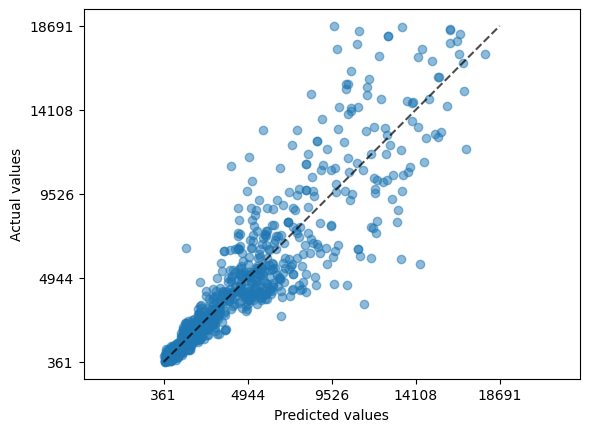

In [19]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'black'}

);

- Точки достаточно плотно расположены вдоль линии, что говорит о хорошей точности модели: предсказанные значения близки к реальным.
- Есть разброс и некоторое отклонение от идеальной линии, особенно для больших значений, что свидетельствует о наличии ошибок прогноза при экстремальных данных.
- Видно, что модель не переоценивает и не занижает систематически, так как точки распределены равномерно по обе стороны от линии.

## Поиск лучших гиперпараметров с помощью рандомизированного поиска

In [20]:
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплировании гиперпараметров
import scipy.stats as stats # статистические функции библиотеки scipy

In [21]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : из какого распределения сэмплируем
# обозначение должно "досимвольно" совпадать с тем что в документации
parameters = {'n_neighbors':stats.randint(1,50), # задаем распределение как равномерное от 1 до 50
              'weights':['uniform', 'distance']}

# количество итераций
n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

Обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` `n_iter` комбинации гиперпараметров по распределению из `param_distributions`

In [22]:
kNN_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.792 total time=   0.1s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.808 total time=   0.1s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.767 total time=   0.1s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.794 total time=   0.1s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.808 total time=   0.1s
[CV 1/5] END ...n_neighbors=41, weights=uniform;, score=0.883 total time=   0.2s
[CV 2/5] END ...n_neighbors=41, weights=uniform;, score=0.884 total time=   0.2s
[CV 3/5] END ...n_neighbors=41, weights=uniform;, score=0.874 total time=   0.2s
[CV 4/5] END ...n_neighbors=41, weights=uniform;, score=0.872 total time=   0.2s
[CV 5/5] END ...n_neighbors=41, weights=uniform;, score=0.891 total time=   0.2s
[CV 1/5] END ...n_neighbors=31, weights=uniform;, score=0.883 total time=   0.1s
[CV 2/5] END ...n_neighbors=31, weights=uniform

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
                   estimator=KNeighborsRegressor(), n_iter=20,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc6896c4740>,
                                        'weights': ['uniform', 'distance']},
                   verbose=3)

Лучший кандидат

In [23]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=35, weights='distance')

In [24]:
kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train_prep, y_train);

In [25]:
print(f"r2 на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9990
r2 на валидационной выборке: 0.8797
mse на тренировочной выборке: 15576.3244
mse на валидационной выборке: 1876430.3195


**Результаты перебора**

In [28]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
4,35,distance,0.883419,0.005383,1
16,38,distance,0.883404,0.005527,2
9,34,distance,0.883362,0.005405,3
8,37,distance,0.883353,0.005436,4
1,41,uniform,0.880873,0.006915,5
15,33,uniform,0.880717,0.006638,6
12,16,distance,0.880678,0.004914,7
5,45,uniform,0.880639,0.006779,8
13,47,uniform,0.880601,0.006684,9
2,31,uniform,0.880533,0.006602,10


Выводы

* в сравнении с линейной регрессией в тех же условиях (только числовые признаки, целевая переменная не предобработаны) модель к-ближайших соседей лучше (метрика r2 на кроссвалидации `0.88`против `0.83`)
* предпочительней тип весов `distance`, хотя стоит отметить большую стабильность типа весов `uniform` (меньше разброс оценок)
* рост числа соседей после `16` не несет значительный вклад

* можно сказать, что в целом нет значительных ошибок как для небольших, так и для больших значений цены

# Оценка влияния предварительной обработки целевой переменной


Необходимо поправить целевую метку, так как она была не нормальная в плане нормального распределения

Для этого используем `TransformedTargetRegressor`

In [29]:
from sklearn.compose import TransformedTargetRegressor

In [31]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=KNeighborsRegressor(n_neighbors = 14),
    transformer=PowerTransformer())
    )
])

In [32]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_carat',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['carat', 'y', 'z']),
                                                 ('num_depth',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['depth', 'table', 'x'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=14),
                                            transformer=PowerTransformer()))])

In [33]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8909
r2 на валидационной выборке: 0.8763
mse на тренировочной выборке: 1751171.4787
mse на валидационной выборке: 1929569.0367


In [34]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.260906,0.073830,0.880335,-1.937432e+06,-783.181222,-10984.920731
1,0.273425,0.072914,0.879132,-1.953201e+06,-794.477580,-10381.778845
2,0.256212,0.073564,0.869865,-2.054636e+06,-805.103566,-15202.887370
3,0.257005,0.070918,0.869068,-2.195279e+06,-828.627148,-17318.497454
4,0.255403,0.068896,0.887420,-1.777256e+06,-754.176284,-9990.954347




test_R2      8.771642e-01
test_-MSE   -1.983561e+06
test_-MAE   -7.931132e+02
test_-Max   -1.277581e+04
dtype: float64


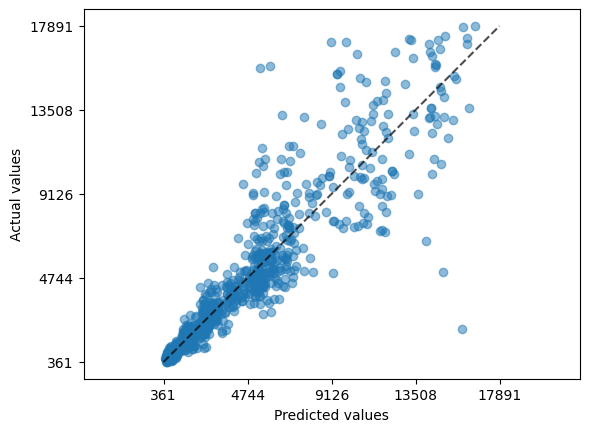

In [35]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'black'}

);

- Модель демонстрирует хорошее согласование предсказаний с реальными значениями, особенно в среднем диапазоне.
- Разброс ошибок увеличивается для больших значений, что может указывать на необходимость дополнительной настройки модели для улучшения прогноза на граничных данных.

## Поиск лучших гиперпараметров по сетке параметров

In [36]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров

from sklearn.metrics import make_scorer #функция для создания объекта из метрики для использования в кросс-валидации

In [37]:
pipe_num_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_carat',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['carat', 'y', 'z']),
                                                 ('num_depth',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['depth', 'table', 'x'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=14),
                                            transformer=PowerTransformer()))])

In [39]:
param_grid = {
    # ВАЖНО: используем "имена", которые есть у компонент Pipeline и разделяем их __ (две земли)
    'preprocessors__num_carat__power__method': [None, 'yeo-johnson', 'box-cox'],
    "model__regressor__n_neighbors": np.arange(1,50,8),
    "model__regressor__weights": ['uniform', 'distance'],
}

In [40]:
scorer = make_scorer(r2_score)

In [41]:
Pipe_GS = GridSearchCV(estimator = pipe_num_transform, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 3 # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_carat',
                                                                         Pipeline(steps=[('power',
                                                                                          PowerTransformer())]),
                                                                         ['carat',
                                                                          'y',
                                                                          'z']),
                                                                        ('num_depth',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['depth',
                                                                          'table',
                                                                          'x'])])),
                                       ('model',
                                        TransformedTar...essor(regressor=KNeighborsRegressor(n_neighbors=14),
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__n_neighbors': array([ 1,  9, 17, 25, 33, 41, 49]),
                         'model__regressor__weights': ['uniform', 'distance'],
                         'preprocessors__num_carat__power__method': [None,
                                                                     'yeo-johnson',
                                                                     'box-cox']},
             scoring=make_scorer(r2_score, response_method='predict'),
             verbose=3)

Обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` все перечисленные комбинации гиперпараметров / аргументов из `param_grid`

In [42]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=None;, score=nan total time=   0.0s
[CV 2/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=None;, score=nan total time=   0.0s
[CV 3/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=None;, score=nan total time=   0.0s
[CV 4/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=None;, score=nan total time=   0.0s
[CV 5/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=None;, score=nan total time=   0.0s
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_carat__power__method=yeo-johnson;, score=0.788 total 

Лучший кандидат

In [43]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_carat',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['carat', 'y', 'z']),
                                                 ('num_depth',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['depth', 'table', 'x'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=np.int64(33),
                                                                          weights='distance'),
                                            transformer=PowerTransformer()))])

In [44]:
Pipe_best.fit(X_train, y_train);

In [45]:
print(f"r2 на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9990
r2 на валидационной выборке: 0.8788
mse на тренировочной выборке: 16029.2647
mse на валидационной выборке: 1890805.7179


### Анализ результатов

На уровне гиперпараметров

In [46]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_carat__power__method', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [48]:
DF_ = DF_Pipe[[ # берем только гиперпараметры,
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_carat__power__method',
                 'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разброс метрики на кросс-валидации
             'rank_test_score',# место
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем расцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__regressor__n_neighbors,param_model__regressor__weights,param_preprocessors__num_carat__power__method,mean_test_score,std_test_score,rank_test_score
28,33,distance,yeo-johnson,0.880604,0.006336,1
34,41,distance,yeo-johnson,0.880583,0.006514,2
40,49,distance,yeo-johnson,0.880456,0.006589,3
22,25,distance,yeo-johnson,0.880313,0.006139,4
16,17,distance,yeo-johnson,0.879309,0.005772,5
31,41,uniform,yeo-johnson,0.878513,0.006864,6
25,33,uniform,yeo-johnson,0.878485,0.006815,7
37,49,uniform,yeo-johnson,0.878331,0.006850,8
19,25,uniform,yeo-johnson,0.878124,0.006804,9
13,17,uniform,yeo-johnson,0.877319,0.006663,10


Выводы:

* Предварительная обработка целевой переменной не так полезна, как для линейной модели (метрики r2 на кроссвалидации осталась `0.88` , против роста с `0.83` до `0.85`)

* предпочительней тип весов `distance`, при этом стоит отметить разброс для типа весов `uniform` не сильно меньше (по сравнению с ситуацией, когда не обрабатывали целевую переменную)

* рост числа соседей после `9` не несет значительный вклад




# Про то как, Сохранять Модель

In [49]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [50]:
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(kNNbest, 'best_knn.joblib')  # чтобы сохранить объект
dump(Pipe_best, 'Pipe_best_knn.joblib')  # чтобы сохранить объект

['Pipe_best_knn.joblib']